# YouTube Data API v3

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# api_key is stored in config.py
import config
import networkx as nx

### 1 - Youtube Search (query, n)
    Returns list of channel dictionaries
### 2 - Youtube Channel List
    Returns details on a specific channel
#### A - Request channel details (channelId)
    Returns a json dictionary for a specific channel Id
#### B - Run Channel List (list of channelIds)
    Returns a list of dictionaries per channel

Search method iterating using tokens to get more than 50 results. 

Uses requests to grab type=channel, part=snippet, order=?;

Creates an empty list, extends the list with the json's reponse items (50 at a time).

### Function to to return a list of maxResults parameter for each api request

 For a given number of requests and a specified batch_size, function will return a list of maxResults. 
 
 For example: (123, 50) returns [50,50,23]

In [2]:
def determine_max_result_list(n, batch_size):
    '''Function to return a list of max results parameters for a specific number of requests and batch_sizes.
    
    For example: (123,50) returns [50,50,23]'''
    # Logic to determine maxResults parameter
    if n%50 == 0:
        request_size_list = [batch_size]*(n//batch_size)
    # Determine a list of request sizes []
    else:
        request_size_list = [batch_size]*(n//batch_size) + [n%batch_size]
    return request_size_list

### Function to request a youtube search response for a given query and number of requests

Returns a list of dictionaries, each dictionary represents a specific channel and their subsequent details.<br>
Also create a channelid_list which comes from ```CHANNEL_LIST[0]['id']```

In [3]:
# Search for channels by a specific query
def request_youtube_search_channels(query, n):
    '''Returns a list of n channels that match the query.\n
    Uses /youtube/v3/search'''
    
    request_size_list = determine_max_result_list(n,50)
        
    # Empty list to store 50 items from each response
    channel_list = list()
    
    # Instantiate nextPageToken, when '' method interprets null
    nextPageToken = ''


    for request_size in request_size_list:

        # Create request object
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/search',
            params=dict(part='snippet', 
                        type='channel',
                        maxResults=request_size,
                        pageToken=nextPageToken,
                        q=query,
                        key=config.api_key)
        )
        nextPageToken = json.loads(resp.content)['nextPageToken']
        channel_list.extend(json.loads(resp.content)['items'])
        #print(len(set(channel['id']['channelId'] for channel in channel_list)))
    return channel_list
#CHANNEL_LIST = request_youtube_search_channels('Minecraft',23)

# Extract Channel Ids from the list of dictionaries
#CHANNELID_LIST = [channel['snippet']['channelId'] for channel in CHANNEL_LIST]

In [4]:
# Get channel details and snippet
def request_channel_list(channelid_list):
    
    # Check for non-unique elements
    if len(channelid_list) != len(set(channelid_list)):
        print("There are non-unique elements in this list")
        
    # Determine request size list
    request_size_list = determine_max_result_list(len(set(channelid_list)),50)

    # Instantiate channel response list
    channel_resp_list = []
    
    # Set the start_index to 0
    start_index = 0
    # Loop 
    for request_size in request_size_list:
        
        # Debug
        #print(request_size_list, request_size, start_index, start_index+request_size)
        
        resp = requests.get(
            'https://www.googleapis.com/youtube/v3/channels',
            params=dict(part='contentDetails, snippet, statistics,\
                        brandingSettings, topicDetails, status, id, contentOwnerDetails',
                    id=channelid_list[start_index:start_index+request_size],
                    maxResults=50,
                    key=config.api_key)
        )
        # Increase the start_index
        start_index += request_size
        
        # Extend channel response list
        channel_resp_list.extend(json.loads(resp.content)['items'])
        
    return channel_resp_list
#CHANNEL_RESP = request_channel_list(CHANNELID_LIST)

In [5]:
def extract_channel_details(channel_resp):
    # Instantite empty channels details list for new dictionary format
    channel_details_list = list()
    
    # Loop over each channel's json dictionary in details_list
    for channel in channel_resp:
        # Instantiate new details dictionary; in series update the dictionary to include relevant details
        channel_details_dict = {}
        channel_details_dict.update(dict(id=channel['id']))
        channel_details_dict.update(channel['snippet'])
        channel_details_dict.update(channel['contentDetails'])
        #channel_details_dict.update(channel['topicDetails'])
        channel_details_dict.update(channel['status'])
        channel_details_dict.update(channel['statistics'])
        channel_details_dict.update(channel['brandingSettings']['channel'])
        
        # Append the added channel's new dictionary format to channel details list
        channel_details_list.append(channel_details_dict)
    return channel_details_list

#CHANNEL_DETAILS_LIST = extract_channel_details(CHANNEL_RESP)

# Insert list of dictionaries into pandas dataframe
#df = pd.DataFrame(CHANNEL_DETAILS_LIST)

# Main

In [6]:
# Request n number of channels from a youtube search
CHANNEL_LIST = request_youtube_search_channels('Coffee',100)

# Retrieve Channel Ids from the list of dictionaries
CHANNELID_LIST = [channel['snippet']['channelId'] for channel in CHANNEL_LIST]

# Request details from each channel
CHANNEL_RESP = request_channel_list(CHANNELID_LIST)

# Extract channel details to a list of dictionaries for pandas
CHANNEL_DETAILS_LIST = extract_channel_details(CHANNEL_RESP)

# Insert list of dictionaries into pandas dataframe
DF = pd.DataFrame(CHANNEL_DETAILS_LIST)

There are non-unique elements in this list


In [7]:
DF.shape

(89, 29)

## NetworkX

In [8]:
# Dictionary comprehension to create channelId:featuredChannelUrls data structure
CHANNEL_NETWORK = {channel['id']:channel['featuredChannelsUrls'] if 'featuredChannelsUrls' in channel.keys() else [] for channel in CHANNEL_DETAILS_LIST}

# Dict Comp to create channelId:Channelname data structure
CHANNEL_NAMES = {channel['id']:channel['title'] if 'title' in channel.keys() else '' for channel in CHANNEL_DETAILS_LIST}

In [11]:
def graph_channels(channel_network, channel_names):
    G = nx.DiGraph(channel_network)
    plt.figure(figsize = (12,12))
    nx.draw_networkx(G,
                 with_labels=True,
                 labels=CHANNEL_NAMES,
                 font_size=12, font_color = 'red')
    return G

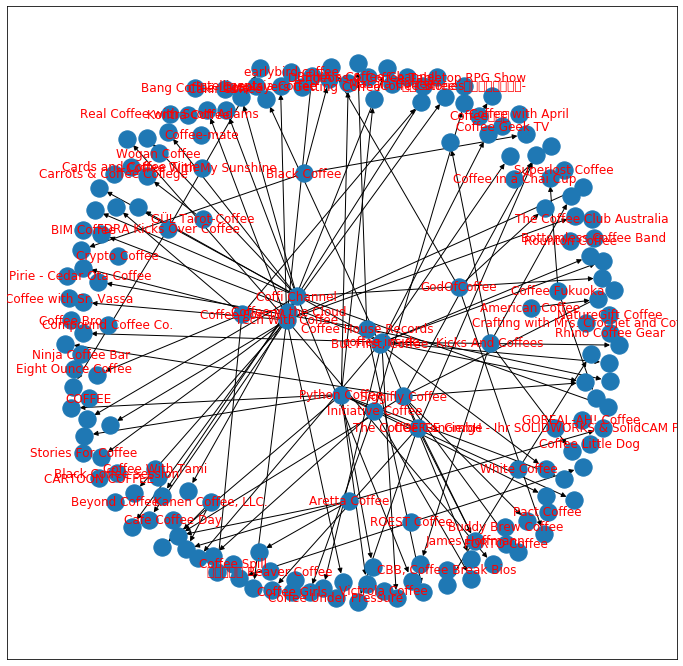

In [12]:
G = graph_channels(CHANNEL_NETWORK, CHANNEL_NAMES)